In [ ]:
# Step 1: Load and Standardize the Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Load data
try:
    df = pd.read_csv('/content/country_level_data_0.csv')
except FileNotFoundError:
    raise FileNotFoundError("Please upload 'country_level_data_0.csv' to the Colab environment.")
print("Original dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

# Filter to African countries (region_id: SSF for Sub-Saharan Africa, MEA for Middle East & North Africa)
african_regions = ['SSF', 'MEA']
df_africa = df[df['region_id'].isin(african_regions)]
print("African dataset shape:", df_africa.shape)

# Drop categorical columns (object dtype)
drop_cols = [col for col in df_africa.columns if df_africa[col].dtype == 'object']
df_africa = df_africa.drop(drop_cols, axis=1, errors='ignore')
# Impute missing values with mean for numeric columns
df_africa = df_africa.fillna(df_africa.mean(numeric_only=True))
print("Initial cleaned dataset shape:", df_africa.shape)

# Identify and handle columns with all NaN after imputation
nan_cols = df_africa.columns[df_africa.isna().all()]
if len(nan_cols) > 0:
    print("Warning: Dropping columns with all NaN values:", nan_cols.tolist())
    df_africa = df_africa.drop(columns=nan_cols)
print("Final cleaned dataset shape:", df_africa.shape)

# Select numeric columns (ensure >10)
numeric_cols = df_africa.select_dtypes(include=[np.number]).columns
print("Numeric columns (count: {}): {}".format(len(numeric_cols), numeric_cols.tolist()))
if len(numeric_cols) < 10:
    raise ValueError("Dataset has fewer than 10 numeric columns after cleaning.")

# Convert to NumPy array
data = df_africa[numeric_cols].values

# Check for columns with all identical or NaN values
data_std = np.std(data, axis=0)
data_mean = np.mean(data, axis=0)
# Identify columns where std is NaN or zero
problematic_cols = np.logical_or(np.isnan(data_std), data_std == 0)
if np.any(problematic_cols):
    print("Warning: Removing columns with NaN or zero standard deviation:", numeric_cols[problematic_cols].tolist())
    data = data[:, ~problematic_cols]
    numeric_cols = numeric_cols[~problematic_cols]
print("Data shape after removing problematic columns:", data.shape)

# Recalculate mean and std for remaining columns
data_mean = np.mean(data, axis=0)
data_std = np.std(data, axis=0)
# Ensure no division by zero and check for NaN
if np.any(np.isnan(data_std)):
    raise ValueError("Standard deviation contains NaN after filtering, check data integrity.")
data_std[data_std == 0] = 1e-10
standardized_data = (data - data_mean) / data_std

print("Standardized data shape:", standardized_data.shape)
print("Standardized data sample (first 5 rows):")
print(standardized_data[:5])
print("Remaining numeric columns:", numeric_cols.tolist())

Original dataset shape: (217, 51)
Columns: ['iso3c', 'region_id', 'country_name', 'income_id', 'gdp', 'composition_food_organic_waste_percent', 'composition_glass_percent', 'composition_metal_percent', 'composition_other_percent', 'composition_paper_cardboard_percent', 'composition_plastic_percent', 'composition_rubber_leather_percent', 'composition_wood_percent', 'composition_yard_garden_green_waste_percent', 'other_information_information_system_for_solid_waste_management', 'other_information_national_agency_to_enforce_solid_waste_laws_and_regulations', 'other_information_national_law_governing_solid_waste_management_in_the_country', 'other_information_ppp_rules_and_regulations', 'other_information_summary_of_key_solid_waste_information_made_available_to_the_public', 'population_population_number_of_people', 'special_waste_agricultural_waste_tons_year', 'special_waste_construction_and_demolition_waste_tons_year', 'special_waste_e_waste_tons_year', 'special_waste_hazardous_waste_tons_

In [ ]:
# Step 3: Calculate the Covariance Matrix
cov_matrix = np.cov(standardized_data.T)
print("Covariance matrix shape:", cov_matrix.shape)
print("Covariance matrix sample (first 5x5):")
print(cov_matrix[:5, :5])

Covariance matrix shape: (35, 35)
Covariance matrix sample (first 5x5):
[[ 1.01470588 -0.02530388  0.21946434  0.29701053 -0.26251591]
 [-0.02530388  1.01470588 -0.3357367  -0.25261374 -0.78519732]
 [ 0.21946434 -0.3357367   1.01470588  0.47612167 -0.11509397]
 [ 0.29701053 -0.25261374  0.47612167  1.01470588 -0.05798009]
 [-0.26251591 -0.78519732 -0.11509397 -0.05798009  1.01470588]]


In [ ]:
# Step 4: Perform Eigendecomposition
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
print("Eigenvalues shape:", eigenvalues.shape)
print("Eigenvalues:", eigenvalues)
print("Eigenvectors shape:", eigenvectors.shape)

Eigenvalues shape: (35,)
Eigenvalues: [6.02782748 4.10412392 2.83319253 2.60265109 2.27996461 2.1125641
 1.67910921 1.47295566 1.27672955 1.198474   1.0220856  1.0196614
 0.94642972 0.88700996 0.81354365 0.64016101 0.56416837 0.51648245
 0.42724514 0.40346952 0.32592129 0.27332597 0.21884789 0.18437958
 0.17095674 0.13877002 0.00675842 0.00889703 0.02646948 0.03342939
 0.05370783 0.06456181 0.07878652 0.08733907 0.        ]
Eigenvectors shape: (35, 35)


In [ ]:
# Step 5: Sort Principal Components
sorted_indices = np.argsort(eigenvalues)[::-1]  # Descending order
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]
print("Sorted eigenvalues:", sorted_eigenvalues)
print("Sorted eigenvectors shape:", sorted_eigenvectors.shape)

Sorted eigenvalues: [6.02782748 4.10412392 2.83319253 2.60265109 2.27996461 2.1125641
 1.67910921 1.47295566 1.27672955 1.198474   1.0220856  1.0196614
 0.94642972 0.88700996 0.81354365 0.64016101 0.56416837 0.51648245
 0.42724514 0.40346952 0.32592129 0.27332597 0.21884789 0.18437958
 0.17095674 0.13877002 0.08733907 0.07878652 0.06456181 0.05370783
 0.03342939 0.02646948 0.00889703 0.00675842 0.        ]
Sorted eigenvectors shape: (35, 35)


In [ ]:
# Step 6: Project Data onto Principal Components
# Task 2: Dynamically select components (95% variance)
explained_variance = sorted_eigenvalues / np.sum(sorted_eigenvalues)
cumulative_variance = np.cumsum(explained_variance)
threshold = 0.95
num_components = np.argmax(cumulative_variance >= threshold) + 1
print(f"Number of components for {threshold*100}% variance: {num_components}")
print("Cumulative variance ratio:", cumulative_variance[:num_components])

# Project data
reduced_data = np.dot(standardized_data, sorted_eigenvectors[:, :num_components])
print("Reduced data shape:", reduced_data.shape)
print("Reduced data sample (first 5 rows):")
print(reduced_data[:5])

Number of components for 95.0% variance: 20
Cumulative variance ratio: [0.17471964 0.29367975 0.37580127 0.45124044 0.51732637 0.57856011
 0.62722994 0.66992431 0.70693096 0.74166934 0.77129501 0.80085041
 0.82828316 0.85399359 0.87757456 0.89612996 0.91248266 0.92745317
 0.93983709 0.95153185]
Reduced data shape: (69, 20)
Reduced data sample (first 5 rows):
[[ 2.05423988e-01  1.30622007e+00 -8.91661340e-01  8.17412746e-01
   5.19129865e-01 -6.94518105e-01  1.05365523e-01  7.85333887e-01
   5.50570979e-01 -2.83840470e-01  5.27597867e-01  4.22511275e-01
   2.41178294e-01  1.58621127e+00 -6.78571310e-01 -1.21892476e+00
   2.71848078e-01 -1.20318359e-01 -6.72541679e-01 -8.55897733e-01]
 [-2.75787880e-01  3.34578404e+00 -1.59447189e+00  1.30409506e+00
   1.38907276e+00 -1.37157712e+00 -1.08651204e+00  1.01819912e+00
  -1.83878999e+00  1.15306457e+00  2.39671466e+00 -3.27889899e-01
  -3.99585197e-01 -4.05379921e-01 -9.38756009e-01  1.39966578e+00
   7.23825987e-01  1.31191113e+00  3.3026173

In [ ]:
# Step 7: Output the Reduced Data
print(f'Reduced Data Shape: {reduced_data.shape}')
print("Reduced data sample (first 5 rows):")
print(reduced_data[:5])

Reduced Data Shape: (69, 20)
Reduced data sample (first 5 rows):
[[ 2.05423988e-01  1.30622007e+00 -8.91661340e-01  8.17412746e-01
   5.19129865e-01 -6.94518105e-01  1.05365523e-01  7.85333887e-01
   5.50570979e-01 -2.83840470e-01  5.27597867e-01  4.22511275e-01
   2.41178294e-01  1.58621127e+00 -6.78571310e-01 -1.21892476e+00
   2.71848078e-01 -1.20318359e-01 -6.72541679e-01 -8.55897733e-01]
 [-2.75787880e-01  3.34578404e+00 -1.59447189e+00  1.30409506e+00
   1.38907276e+00 -1.37157712e+00 -1.08651204e+00  1.01819912e+00
  -1.83878999e+00  1.15306457e+00  2.39671466e+00 -3.27889899e-01
  -3.99585197e-01 -4.05379921e-01 -9.38756009e-01  1.39966578e+00
   7.23825987e-01  1.31191113e+00  3.30261735e-01 -2.52323692e-01]
 [ 2.25264547e-01 -1.01506200e+00  1.31888305e+00 -9.37182494e-01
  -9.36763536e-02  6.89943254e-02 -4.88110448e-01  9.37172951e-01
   6.55530141e-02 -3.42676443e-01  2.48823382e-01  5.34501566e-01
   1.19277175e+00  2.49831542e-03  6.75183725e-01 -7.19016236e-02
  -6.5723

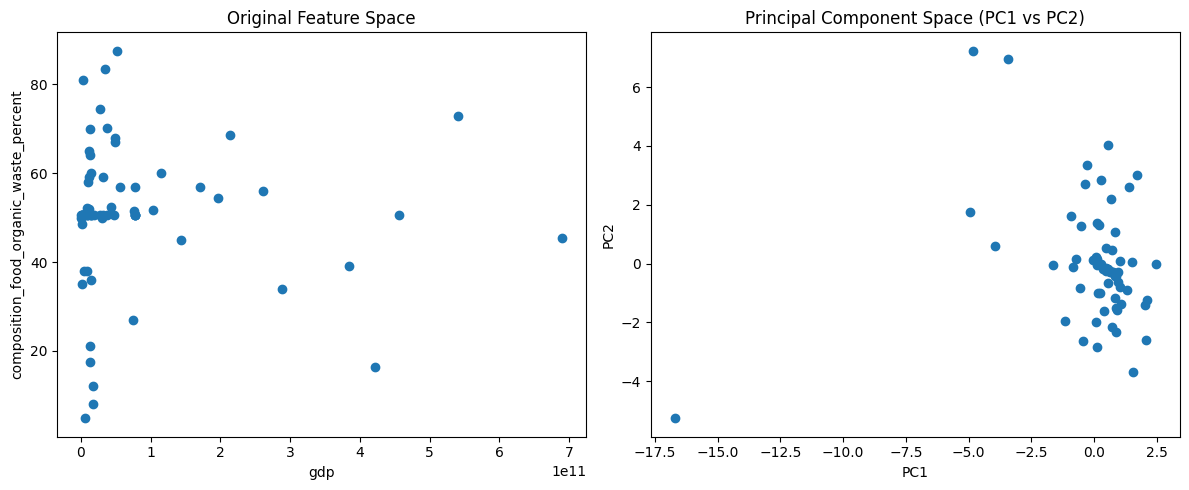

In [ ]:
# Step 8: Visualize Before and After PCA
plt.figure(figsize=(12, 5))

# Plot original data (first two remaining numeric columns)
plt.subplot(1, 2, 1)
plt.scatter(df_africa[numeric_cols[0]], df_africa[numeric_cols[1]])
plt.xlabel(numeric_cols[0])
plt.ylabel(numeric_cols[1])
plt.title('Original Feature Space')

# Plot reduced data (PC1 vs PC2)
plt.subplot(1, 2, 2)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Principal Component Space (PC1 vs PC2)')

plt.tight_layout()
plt.show()

# Explanation: The original plot shows two waste management features (e.g., 'gdp' vs. 'composition_food_organic_waste_percent'). After PCA, data is projected onto PC1 and PC2, capturing maximum variance. Clusters/spread are preserved but rotated/scaled, reducing dimensionality while retaining 95% variance.

In [48]:
# Task 3: Optimize PCA for Large Datasets (SVD)
from timeit import default_timer as timer

def pca_eig(X):
    cov = np.cov(X.T)
    np.linalg.eig(cov)

def pca_svd(X):
    U, S, Vh = np.linalg.svd(X, full_matrices=False)

# Time on current data
start = timer()
pca_eig(standardized_data)
end = timer()
print("Eig time:", end - start)

start = timer()
pca_svd(standardized_data)
end = timer()
print("SVD time:", end - start)

# Test on large synthetic dataset
large_X = np.random.rand(10000, 50)
start = timer()
pca_eig(large_X)
end = timer()
print("Eig time on large data:", end - start)

start = timer()
pca_svd(large_X)
end = timer()
print("SVD time on large data:", end - start)

# SVD-based PCA
U, S, Vh = np.linalg.svd(standardized_data, full_matrices=False)
svd_eigenvalues = S**2 / (standardized_data.shape[0] - 1)
svd_eigenvectors = Vh.T
print("Explained variance from SVD:", svd_eigenvalues / np.sum(svd_eigenvalues))

Eig time: 0.005411498000285064
SVD time: 0.001547110999126744
Eig time on large data: 0.006945183999960136
SVD time on large data: 0.053968446999533626
Explained variance from SVD: [0.16972765 0.11556125 0.07977519 0.07328376 0.06419776 0.05948421
 0.04727927 0.04147453 0.03594932 0.03374585 0.02877922 0.02871096
 0.02857143 0.02664895 0.02497585 0.02290723 0.01802524 0.01588549
 0.01454278 0.01203009 0.01136063 0.00917708 0.00769613 0.00616218
 0.00519164 0.00481369 0.0039074  0.00245924 0.00221842 0.00181789
 0.00151227 0.00094128 0.00074531 0.00025052 0.0001903 ]


In [ ]:
%%writefile mypca.py
import numpy as np

class MyPCA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.eig_vals = None
        self.eig_vecs = None
        self.explained_variance_ratio_ = None

    def fit(self, X):
        U, S, Vh = np.linalg.svd(X, full_matrices=False)
        self.eig_vals = S**2 / (X.shape[0] - 1)
        self.eig_vecs = Vh.T
        self.explained_variance_ratio_ = self.eig_vals / np.sum(self.eig_vals)

    def transform(self, X):
        if self.n_components is None:
            k = len(self.eig_vals)
        else:
            k = self.n_components
        return np.dot(X, self.eig_vecs[:, :k])

    def choose_n_components(self, threshold=0.95):
        if self.explained_variance_ratio_ is None:
            raise ValueError("Fit the model first.")
        cum_var = np.cumsum(self.explained_variance_ratio_)
        return np.argmax(cum_var >= threshold) + 1

Writing mypca.py


In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
